In [52]:
## Status, as of June 28, 2016:
## - Pretty much done, although I'd like to convert the nested for loop into a window function call.
## - Would like to add all years and do a final large panel plot that highlights outliers per year.

## Prep the workspace
library("AzureML")
ws <- workspace()

## load the data: Read all arrests files and merge into one massive data frame.
## Please note: We could automate file name detection/grabbing in a local version of this, but we're
## trying to lean on Azure ML's processing power, so we've gotta' work with their obfuscation of
## dataset paths.
file_names <- c("ca_doj_arrests_deidentified_2014_05-07-2016.csv",
                "ca_doj_arrests_deidentified_2013_05-07-2016.csv",
                "ca_doj_arrests_deidentified_2012_05-07-2016.csv",
                "ca_doj_arrests_deidentified_2011_05-07-2016.csv")
dat_arrests <- do.call(rbind, download.datasets(ws, file_names))

## Remove row names
row.names(dat_arrests) <- NULL

## Then, read county pop by race and gender.
dat_pop <- download.datasets(ws, "ca_county_population_by_race_gender_age_2005-2014_02-05-2016.csv")

In [53]:
## Preview the arrests data
dim(dat_arrests)
names(dat_arrests)
head(dat_arrests,3)
tail(dat_arrests,3)

[1] 4924073      16

[1] "county"                   "agency_name"             
 [3] "agency_code"              "arrest_year"             
 [5] "arrest_month"             "arrest_day"              
 [7] "race_or_ethnicity"        "gender"                  
 [9] "age_group"                "summary_offense_level"   
[11] "offense_level"            "bcs_offense_code"        
[13] "bcs_summary_offence_code" "fbi_offense_code"        
[15] "status_type"              "disposition"

,county,agency_name,agency_code,arrest_year,arrest_month,arrest_day,race_or_ethnicity,gender,age_group,summary_offense_level,offense_level,bcs_offense_code,bcs_summary_offence_code,fbi_offense_code,status_type,disposition
1,Alameda,Alameda Co. Sheriff's Department,0100,2014,1,1,Black,male,adult,misdemeanor,misdemeanor,856,51,21,booked,misdemeanor complaint sought
2,Alameda,Alameda Co. Sheriff's Department,0100,2014,1,1,Hispanic,male,adult,misdemeanor,misdemeanor,856,51,21,booked,misdemeanor complaint sought
3,Alameda,Alameda Co. Sheriff's Department,0100,2014,1,1,Hispanic,male,adult,misdemeanor,misdemeanor,397,30,08,booked,misdemeanor complaint sought


,county,agency_name,agency_code,arrest_year,arrest_month,arrest_day,race_or_ethnicity,gender,age_group,summary_offense_level,offense_level,bcs_offense_code,bcs_summary_offence_code,fbi_offense_code,status_type,disposition
4924071,Yuba,CA Highway Patrol - Yuba,5899,2011,12,23,White,male,adult,misdemeanor,misdemeanor,856,51,21,booked,misdemeanor complaint sought
4924072,Yuba,CA Highway Patrol - Yuba,5899,2011,12,31,White,female,adult,misdemeanor,misdemeanor,856,51,21,booked,misdemeanor complaint sought
4924073,Yuba,CA Highway Patrol - Yuba,5899,2011,12,31,White,male,adult,misdemeanor,misdemeanor,856,51,21,booked,misdemeanor complaint sought


In [54]:
## Load necessary libraries
library(dplyr)
library(ggplot2)
library(grid)
library(stats)

In [55]:
## Subset arrests to only juveniles.
dat_juv <- dat_arrests[dat_arrests$age_group %in% "juvenile",]

## Group by county, then by year, then by race/ethnicity and give me the counts.
cty_ethnic <- summarise(group_by(dat_juv, county, arrest_year, race_or_ethnicity), total = n())

## Now remove those records supressed due to privacy concern.
cty_ethnic <- cty_ethnic[!(cty_ethnic$race_or_ethnicity %in% "suppressed_due_to_privacy_concern"),]

#### !! Some counties are reporting only "NA"s in their arrest totals per ethnic group. :-\
## Let's remove those from our analysis...for now.
cty_ethnic <- cty_ethnic[!is.na(cty_ethnic$total),]

## Preview
dim(cty_ethnic)
head(cty_ethnic)
tail(cty_ethnic)

[1] 673   4

,county,arrest_year,race_or_ethnicity,total
1,Alameda,2011,Asian/Pacific Islander,274
2,Alameda,2011,Black,1735
3,Alameda,2011,Hispanic,1197
4,Alameda,2011,Other,139
5,Alameda,2011,White,700
6,Alameda,2012,Asian/Pacific Islander,241


,county,arrest_year,race_or_ethnicity,total
1,Yolo,2013,White,96
2,Yolo,2014,Asian/Pacific Islander,8
3,Yolo,2014,Black,32
4,Yolo,2014,Hispanic,108
5,Yolo,2014,Other,5
6,Yolo,2014,White,117


Warning message:
In grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font width unknown for character 0xdWarning message:
In grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font width unknown for character 0xdWarning message:
In grid.Call.graphics(L_text, as.graphicsAnnot(x$label), x$x, x$y, : font width unknown for character 0xd

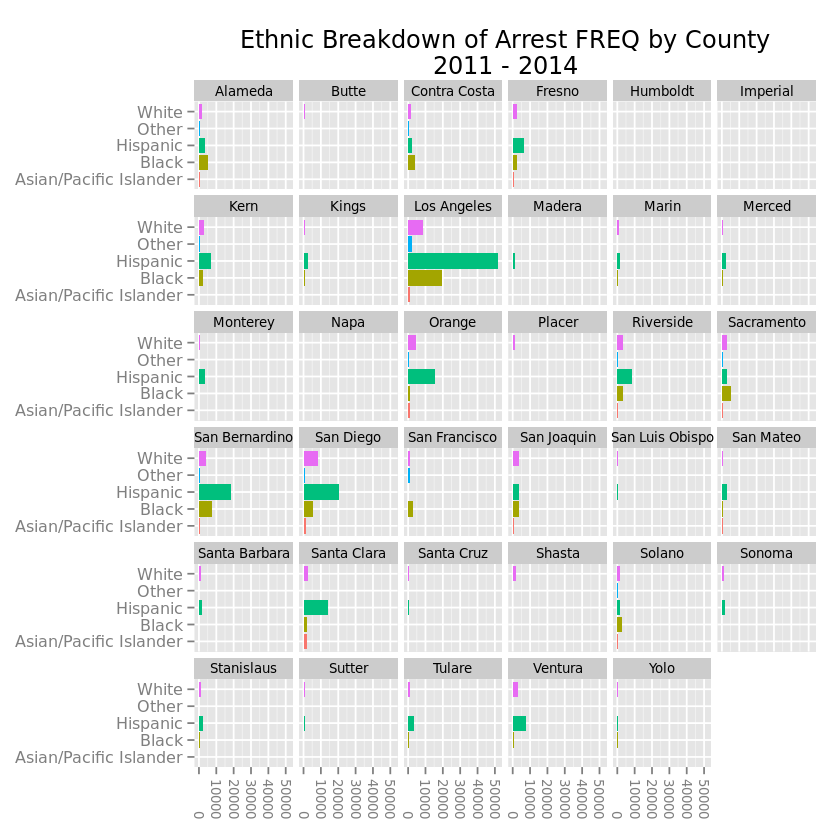

In [56]:
## Panel bar charts: ethnic breakdown of arrests, by county.
## Note: this is sheerly by count (not rate).
plot_ethnic <- ggplot(cty_ethnic, aes(x = race_or_ethnicity, y = total, fill = race_or_ethnicity)) + 
                geom_bar(stat = "identity") + coord_flip() + facet_wrap(~county) +  
                theme(axis.text.x=element_text(angle=-90,hjust=1,vjust=0.5, size = 8), axis.text.x=element_text(size = 8),
                      legend.position = "none", strip.text=element_text(size = 8), axis.title.x=element_blank(),
                      axis.title.y=element_blank()) +
                ggtitle("Ethnic Breakdown of Arrest FREQ by County\r
2011 - 2014")

## Print plot
plot_ethnic

Warning message:
In grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font width unknown for character 0xdWarning message:
In grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font width unknown for character 0xdWarning message:
In grid.Call.graphics(L_text, as.graphicsAnnot(x$label), x$x, x$y, : font width unknown for character 0xd

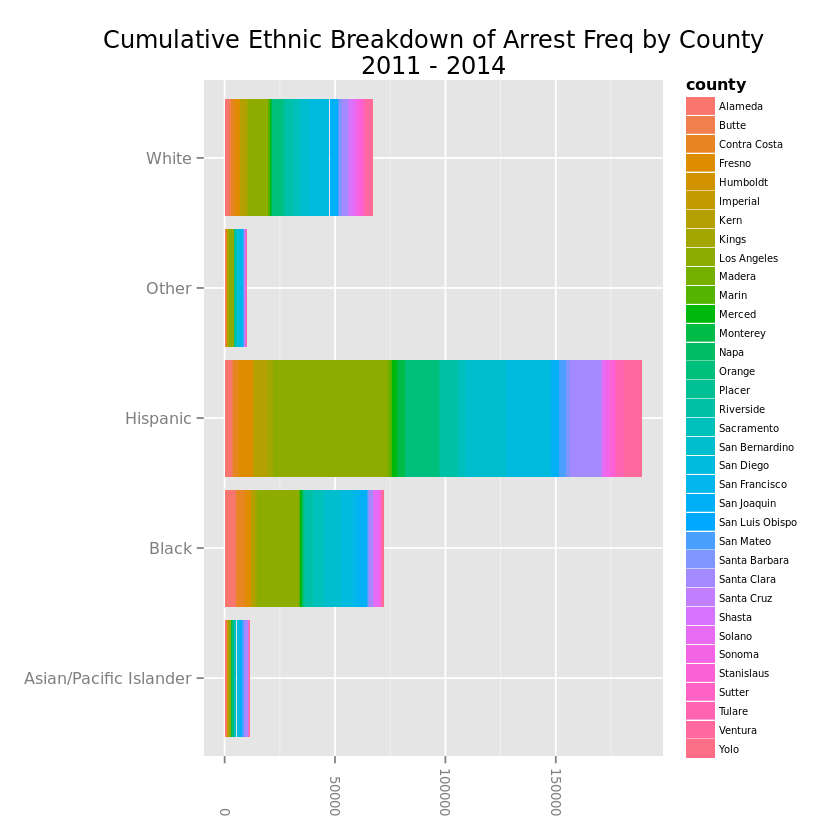

In [57]:
## Stacked bar chart: ethnic breakdown of arrests, stacked between counties.
## Again, this is before normalizing by ethnic population.
plot_ethnic2 <- ggplot(cty_ethnic, aes(x = race_or_ethnicity, y = total, fill = county)) + 
                geom_bar(stat = "identity") + coord_flip() + 
                theme(axis.text.x=element_text(angle=-90,hjust=1,vjust=0.5, size = 8), axis.text.x=element_text(size = 8),
                      strip.text=element_text(size = 8), axis.title.x=element_blank(), axis.title.y=element_blank(),
                      legend.text=element_text(size= 6), legend.key.height=unit(.4, "cm")) +
                ggtitle("Cumulative Ethnic Breakdown of Arrest Freq by County\r
2011 - 2014")

## Print plot
plot_ethnic2

In [58]:
## Now, let's preview the population data
dim(dat_pop)
names(dat_pop)
head(dat_pop)
tail(dat_pop)

[1] 148680      6

[1] "year"       "county"     "race"       "gender"     "age_group" 
[6] "population"

,year,county,race,gender,age_group,population
1,2005,Alameda,All Combined,All Combined,All Combined,1459881
2,2005,Alameda,All Combined,All Combined,Juvenile,354877
3,2005,Alameda,All Combined,All Combined,Adult,1105004
4,2005,Alameda,All Combined,All Combined,0-9,192318
5,2005,Alameda,All Combined,All Combined,10-14,101688
6,2005,Alameda,All Combined,All Combined,15-17,60871


,year,county,race,gender,age_group,population
148675,2014,Yuba,Other,Male,18-24,235
148676,2014,Yuba,Other,Male,25-29,102
148677,2014,Yuba,Other,Male,30-39,210
148678,2014,Yuba,Other,Male,40-49,154
148679,2014,Yuba,Other,Male,50-59,142
148680,2014,Yuba,Other,Male,60+,148


In [59]:
## Looks like it's already aggregated along a number of dimensions. 
## Let's subset only the juveniles.
dat_pop_jv <- dat_pop[dat_pop$age_group %in% "Juvenile",]
head(dat_pop_jv)

,year,county,race,gender,age_group,population
2,2005,Alameda,All Combined,All Combined,Juvenile,354877
14,2005,Alameda,All Combined,Female,Juvenile,173570
26,2005,Alameda,All Combined,Male,Juvenile,181307
38,2005,Alameda,Hispanic,All Combined,Juvenile,103616
50,2005,Alameda,Hispanic,Female,Juvenile,50726
62,2005,Alameda,Hispanic,Male,Juvenile,52890


In [60]:
## Ok, now, let's look at arrests of both genders and ignore the 'all combined' county value.
dat_pop_jv <- dat_pop_jv[dat_pop_jv$gender %in% "All Combined" & !(dat_pop_jv$county %in% "All Combined"),]

## Let's also remove the race 'all combined.'
dat_pop_jv <- dat_pop_jv[!(dat_pop_jv$race %in% "All Combined"),]

head(dat_pop_jv)
tail(dat_pop_jv)

,year,county,race,gender,age_group,population
38,2005,Alameda,Hispanic,All Combined,Juvenile,103616
74,2005,Alameda,Black,All Combined,Juvenile,49014
110,2005,Alameda,White,All Combined,Juvenile,94600
146,2005,Alameda,Asian/Pacific Islander,All Combined,Juvenile,84980
182,2005,Alameda,Native American,All Combined,Juvenile,929
218,2005,Alameda,Other,All Combined,Juvenile,21737


,year,county,race,gender,age_group,population
148466,2014,Yuba,Hispanic,All Combined,Juvenile,7234
148502,2014,Yuba,Black,All Combined,Juvenile,568
148538,2014,Yuba,White,All Combined,Juvenile,10187
148574,2014,Yuba,Asian/Pacific Islander,All Combined,Juvenile,1506
148610,2014,Yuba,Native American,All Combined,Juvenile,307
148646,2014,Yuba,Other,All Combined,Juvenile,1552


In [61]:
## Looks like we'll have to do some recoding/classification, if we want to look at
## Native American, Other, or suppressed_due_to_privacy_concern populations.
unique(dat_juv$race_or_ethnicity)
unique(dat_pop_jv$race)

[1] "Black"                             "Hispanic"                         
[3] "White"                             "Asian/Pacific Islander"           
[5] "Other"                             "suppressed_due_to_privacy_concern"

[1] "Hispanic"               "Black"                  "White"                 
[4] "Asian/Pacific Islander" "Native American"        "Other"

In [62]:
## Join the pop and arrests datasets.
## Start by relabeling the 'race' variable in the pop table. Also, until we've bound all years together, 
## !! Subsetting pop figures to 2011-2014, for now.
names(dat_pop_jv)[3] <- "race_or_ethnicity"
names(cty_ethnic)[2] <- "year"
dat_joined <- right_join(cty_ethnic, dat_pop_jv[dat_pop_jv$year %in% c("2011","2012","2013","2014"),], 
                         by = c("county","year","race_or_ethnicity"))

In [63]:
## Preview to confirm. 
head(dat_joined[!(dat_joined$county %in% "Alpine" | dat_joined$county %in% "Amador" | dat_joined$county %in% "Yuba"),])
tail(dat_joined[!(dat_joined$county %in% "Alpine" | dat_joined$county %in% "Amador" | dat_joined$county %in% "Yuba"),])

,county,year,race_or_ethnicity,total,gender,age_group,population
1,Alameda,2011,Hispanic,1197,All Combined,Juvenile,108656
2,Alameda,2011,Black,1735,All Combined,Juvenile,40241
3,Alameda,2011,White,700,All Combined,Juvenile,78876
4,Alameda,2011,Asian/Pacific Islander,274,All Combined,Juvenile,87100
5,Alameda,2011,Native American,NA,All Combined,Juvenile,818
6,Alameda,2011,Other,139,All Combined,Juvenile,24978


,county,year,race_or_ethnicity,total,gender,age_group,population
1,Yolo,2014,Hispanic,108,All Combined,Juvenile,19981
2,Yolo,2014,Black,32,All Combined,Juvenile,999
3,Yolo,2014,White,117,All Combined,Juvenile,16625
4,Yolo,2014,Asian/Pacific Islander,8,All Combined,Juvenile,4069
5,Yolo,2014,Native American,NA,All Combined,Juvenile,215
6,Yolo,2014,Other,5,All Combined,Juvenile,2629


Warning message:
In grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font width unknown for character 0xdWarning message:
In grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font width unknown for character 0xdWarning message:
In grid.Call.graphics(L_text, as.graphicsAnnot(x$label), x$x, x$y, : font width unknown for character 0xd

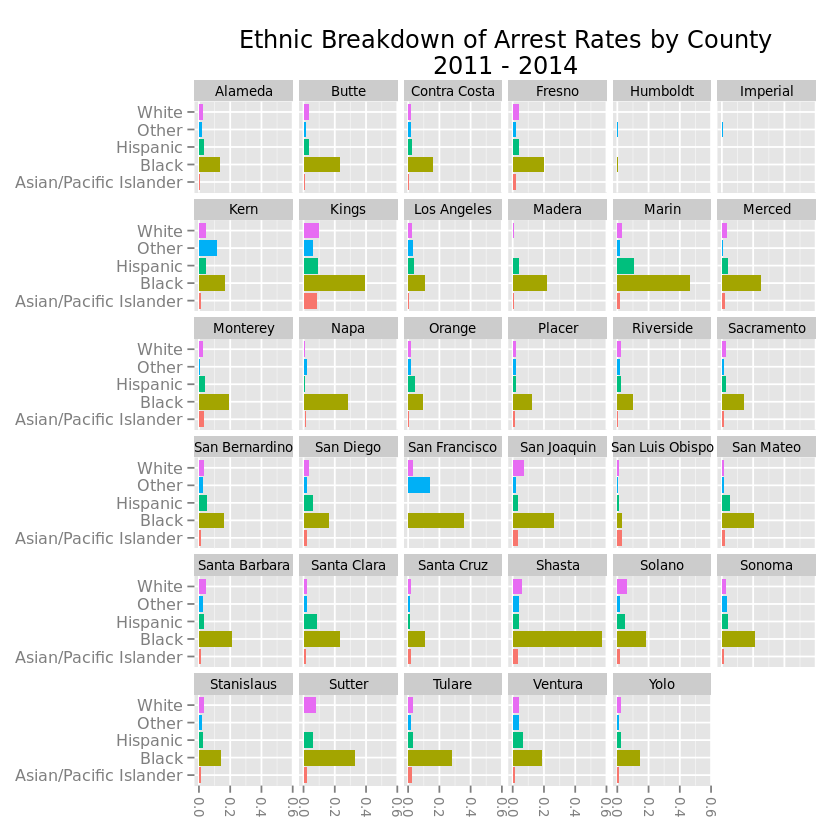

In [64]:
## !! Let's sub out those counties that aren't represented in the arrests file.
dat_joined <- dat_joined[!(dat_joined$county %in% "Alpine" | 
                           dat_joined$county %in% "Amador" |
                           dat_joined$county %in% "Yuba"),]

## Let's remove post-join arrest total NAs from our analysis...for now.
dat_joined <- dat_joined[!is.na(dat_joined$total),]

## Now, let's try that first panel plot, but normalized by population.
plot_ethnic_norm <- ggplot(dat_joined[!(dat_joined$race_or_ethnicity %in% "Native American"),], 
                        aes(x = race_or_ethnicity, y = total/population, fill = race_or_ethnicity), na.rm=T) + 
                        geom_bar(stat = "identity") + coord_flip() + facet_wrap(~county) +  
                        theme(axis.text.x=element_text(angle=-90,hjust=1,vjust=0.5, size = 8), axis.text.x=element_text(size = 8),
                        legend.position = "none", strip.text=element_text(size = 8), axis.title.x=element_blank(),
                        axis.title.y=element_blank()) +
                        ggtitle("Ethnic Breakdown of Arrest Rates by County\r
2011 - 2014")

## Print plot
plot_ethnic_norm

In [65]:
## Add a column just for arrest rate by ethnic population per county.
dat_joined$eth_arrest_rate <- round((dat_joined$total)/(dat_joined$population), 5)

In [66]:
#### Looping approach (Please don't hate me, Rocio! I'll vectorize asap :)) ####

## Create empty dataframe
dat_stats <- dat_joined[0,]
dat_stats$rate_prob <- numeric(0)
dat_stats$z_score <- numeric(0)

## Nested loop (computing stats per race/ethnic group, per year)
for(i in unique(dat_joined$year)){
    
    ## Subset to iterative year
    dat_year <- dat_joined[dat_joined$year %in% i,]
    
    for(j in unique(dat_year$race_or_ethnicity)){
        
        ## Subset to iterative race/ethnicity
        dat_race <- dat_year[dat_year$race_or_ethnicity %in% j,]
        
        ## Compute the probability of the observed arrest rate
        dat_race$rate_prob <- round(pnorm(dat_race$eth_arrest_rate, mean(dat_race$eth_arrest_rate, na.rm = T), 
                                    sd(dat_race$eth_arrest_rate, na.rm = T), lower.tail = FALSE, log.p = FALSE), 5)
        
        ## Compute the Z-score of the observed arrest rates
        dat_race$z_score <- qnorm(dat_race$rate_prob, lower.tail = FALSE, log.p = FALSE)
        
        ## Bind to burgeoning dataframe
        dat_stats <- rbind(dat_stats, dat_race)
    }
}

## Now, show me those who have evidently been outliers in enforcement upon any ethnic group for any year.
dat_stats[dat_stats$z_score >= 1.5,]

,county,year,race_or_ethnicity,total,gender,age_group,population,eth_arrest_rate,rate_prob,z_score
1,Marin,2011,Hispanic,546,All Combined,Juvenile,11659,0.04683,6e-05,3.846126
2,Santa Clara,2011,Hispanic,4783,All Combined,Juvenile,157489,0.03037,0.02328,1.990281
3,Marin,2011,Black,157,All Combined,Juvenile,1095,0.14338,0.00383,2.6667
4,San Francisco,2011,Black,832,All Combined,Juvenile,7504,0.11087,0.05463,1.601528
5,Shasta,2011,Black,63,All Combined,Juvenile,434,0.14516,0.00322,2.724495
6,Kings,2011,White,266,All Combined,Juvenile,9907,0.02685,0.00222,2.845082
7,Shasta,2011,White,536,All Combined,Juvenile,28371,0.01889,0.06646,1.502686
8,Solano,2011,White,595,All Combined,Juvenile,28377,0.02097,0.03191,1.853435
9,Sutter,2011,White,208,All Combined,Juvenile,9984,0.02083,0.03364,1.829799
10,Kings,2011,Asian/Pacific Islander,17,All Combined,Juvenile,1159,0.01467,7e-04,3.194651


In [67]:
## Interesting. There seem to be a lot of the same few counties represented.
## Thus, let's draw up a frequency table of the instances per outlying county from above.
table(dat_stats[dat_stats$z_score >= 2, "county"])


           Kern           Kings           Marin   San Francisco     San Joaquin 
              3              11               5               4               1 
San Luis Obispo     Santa Clara          Shasta          Sutter 
              1               2               5               3 

In [68]:
## Two counties stick out to this researcher: 
## Kings, for its sheer volume of outlying instances, and San Francisco, because, well, it's a 
## little strange to see San Francisco in there, given how "cosmopolitan" it's often considered.

## That said, let's first isolate Kings cases to see if there's a pattern.
dat_stats[dat_stats$z_score >= 2 & dat_stats$county %in% "Kings",]

## VERY interesting. One will note that Kings is an outlier for enforcement upon at least one ethnic
## group per year. HOWEVER, in only one of those years were they an outlier for blacks. Indeed, it
## seems their outlying arrest rates span their application to most every other race/ethnic group.
## What is so different about Kings???

,county,year,race_or_ethnicity,total,gender,age_group,population,eth_arrest_rate,rate_prob,z_score
1,Kings,2011,White,266,All Combined,Juvenile,9907,0.02685,0.00222,2.845082
2,Kings,2011,Asian/Pacific Islander,17,All Combined,Juvenile,1159,0.01467,7e-04,3.194651
3,Kings,2012,Black,187,All Combined,Juvenile,1451,0.12888,0.01754,2.107434
4,Kings,2012,White,237,All Combined,Juvenile,9162,0.02587,0.0019,2.894304
5,Kings,2013,Hispanic,644,All Combined,Juvenile,26441,0.02436,0.00188,2.897625
6,Kings,2013,White,201,All Combined,Juvenile,8790,0.02287,0.00166,2.936443
7,Kings,2013,Asian/Pacific Islander,17,All Combined,Juvenile,1018,0.0167,0.00014,3.633134
8,Kings,2014,Hispanic,589,All Combined,Juvenile,26733,0.02203,0.0022,2.847963
9,Kings,2014,White,209,All Combined,Juvenile,8628,0.02422,6e-05,3.846126
10,Kings,2014,Asian/Pacific Islander,45,All Combined,Juvenile,995,0.04523,0,Inf


In [69]:
## Now, let's isolate those SF cases to see if there's a pattern there.
dat_stats[dat_stats$z_score >= 2 & dat_stats$county %in% "San Francisco",]

## AH, San Francisco is an outlier for enforcement upon those classified as 'Other' in every year
## within our dataset. There's two ways one can interpret this: Either San Francisco is indeed
## extremely cosmopolitan and the high number of 'Other' designees simply points to the proportion
## of mixed race/ethnicity one might assume such a city to have, OR, for some operational policy
## reason, SFPD is simply choosing to label arrested juveniles who match some demographic conditions
## as 'Other.'

,county,year,race_or_ethnicity,total,gender,age_group,population,eth_arrest_rate,rate_prob,z_score
1,San Francisco,2011,Other,426,All Combined,Juvenile,8722,0.04884,0,Inf
2,San Francisco,2012,Other,348,All Combined,Juvenile,9251,0.03762,3e-04,3.431614
3,San Francisco,2013,Other,307,All Combined,Juvenile,9862,0.03113,0.00015,3.6153
4,San Francisco,2014,Other,257,All Combined,Juvenile,10500,0.02448,0.00044,3.326323


In [70]:
# ## Vectorization / Window function approach (for practice!)
# 
# prob_fun <- function(x){
#     round(pnorm(x, mean(x, na.rm = T), sd(x, na.rm = T), lower.tail = FALSE, log.p = FALSE), 5)
# }
# zscore_fun <- function(x){
#     round(qnorm(x$rate_prob, lower.tail = FALSE, log.p = FALSE), 5)
# }
# 
# dat_wstats <- aggregate(eth_arrest_rate ~ year + county, data = dat_joined, FUN = prob_fun, na.action = "na.pass")
# 
# #dat_wstats
# names(dat_wstats)[3] <- "rate_prob"
# 
# dat_wstats


	Shapiro-Wilk normality test

data:  dat_stats_test$eth_arrest_rate
W = 0.9398, p-value = 0.06084



	Shapiro-Wilk normality test

data:  dat_stats_test$eth_arrest_rate[dat_stats_test$z_score < 2]
W = 0.9745, p-value = 0.6326


Warning message:
In title(...): font width unknown for character 0xdWarning message:
In title(...): font width unknown for character 0xd

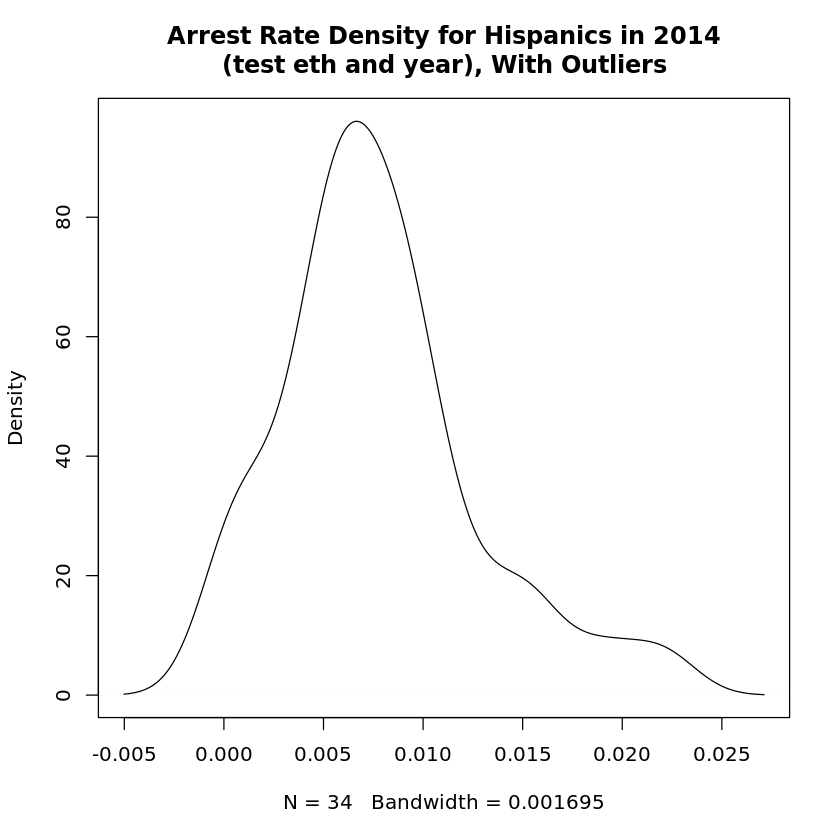

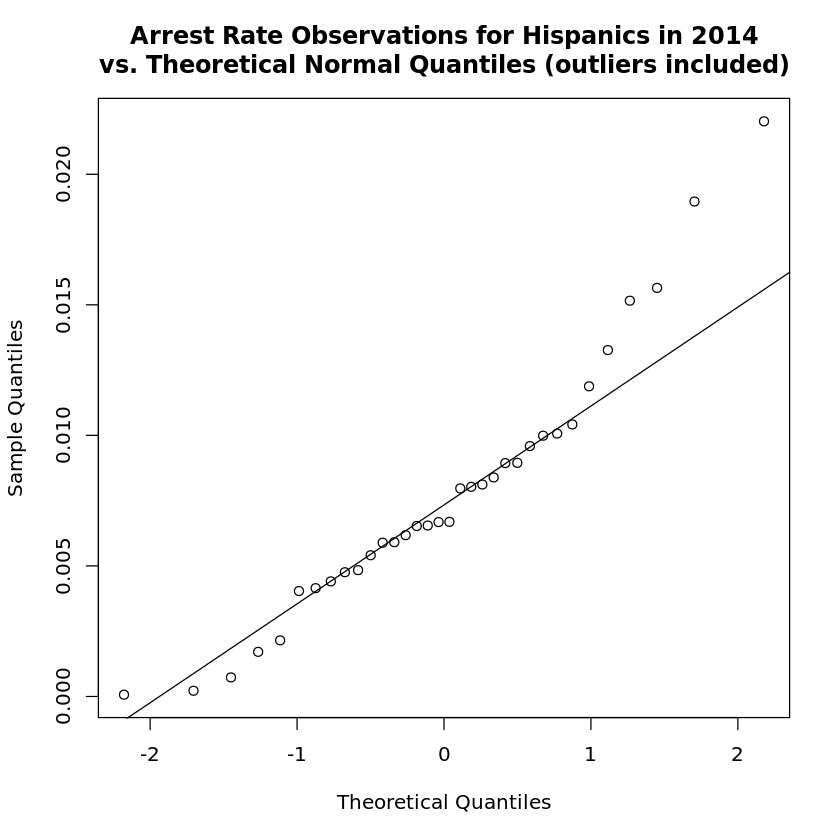

In [110]:
## It'd be a good idea to check whether our assumptions over a normal distribution (because we're 
## employing z-scores) are true.

## Choose a test subset
dat_stats_test <- dat_stats[dat_stats$year %in% "2014" & dat_stats$race_or_ethnicity %in% "Hispanic",]

## Test for difference between observed distribution and normal distribution (Shapiro-Wilk normality test). 
## If difference's p is < .05, then the observed distribution is not sufficiently normal.
shapiro.test(dat_stats_test$eth_arrest_rate)

## See what happens if we exclude the outliers. Depending on the number of outliers, this should
## be even closer to normal.
shapiro.test(dat_stats_test$eth_arrest_rate[dat_stats_test$z_score < 2])

## Plot the density w/outliers
plot(density(dat_stats_test$eth_arrest_rate), 
     main = "Arrest Rate Density for Hispanics in 2014\r
(test eth and year), With Outliers")

## Plot vs. purely normal distribution
qqnorm(dat_stats_test$eth_arrest_rate, main = "Arrest Rate Observations for Hispanics in 2014\r
vs. Theoretical Normal Quantiles (outliers included)")
qqline(dat_stats_test$eth_arrest_rate)

In [113]:
## Save full stats df to csv
write.csv(dat_stats, "dat_stats_2011-2014.csv", row.names = F)

## Save outliers only to csv
write.csv(dat_stats[dat_stats$z_score > 2,], "dat_stats_outliers_2011-2014.csv", row.names = F)

In [ ]:
## Next step: Add all years' datasets and maybe create a large panel plot, faceted by year, between 
## counties and their per-race/ethnic group arrest rates.